# COMP4318/5318 Assignment 2: Image Classification

### 

### Group number: 200 , SID1: 540799107 , SID2: 550224709 , SID3: 520534353 

This template notebook includes code to load the  dataset and a skeleton for the main sections that should be included in the notebook. Please stick to this struture for your submitted notebook.

Please focus on making your code clear, with appropriate variable names and whitespace. Include comments and markdown text to aid the readability of your code where relevant. See the specification and marking criteria in the associated specification to guide you when completing your implementation.

## Setup and dependencies
Please use this section to list and set up all your required libraries/dependencies and your plotting environment. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import sys
import pandas as pd
import sklearn
import numpy as np
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from joblib import Parallel, delayed
from itertools import product
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow import keras
from sklearn.model_selection import GridSearchCV
%matplotlib inline
import matplotlib as mpl
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from kerastuner.tuners import RandomSearch


C:\Users\gkz25\AppData\Local\Temp\ipykernel_26884\107757361.py:33: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
seed = 42
np.random.seed(seed)      
random.seed(seed)          
tf.random.set_seed(seed)   
tf.keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism() 

## 1. Data loading, exploration, and preprocessing


Code to load the dataset is provided in the following cell. Please proceed with your data exploration and preprocessing in the remainder of this section.

In [3]:
# Load the dataset training and test sets as numpy arrays
# assuming Assignment2Data folder is present in the same directory 
# as the notebook
X_train = np.load('Assignment2Data/X_train.npy')
y_train = np.load('Assignment2Data/y_train.npy')
X_test = np.load('Assignment2Data/X_test.npy')
y_test = np.load('Assignment2Data/y_test.npy')

In [4]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (32000, 28, 28, 3)
Shape of X_test: (8000, 28, 28, 3)
Shape of y_train: (32000,)
Shape of y_test: (8000,)


In [5]:
X_train, X_valid, y_train, y_valid= train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

### Examples of preprocessed data

In [6]:
print(f"Shape of X_train: {X_train.shape}")
print(f"shape of X_valid: {X_valid.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_valid: {y_valid.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (25600, 28, 28, 3)
shape of X_valid: (6400, 28, 28, 3)
Shape of X_test: (8000, 28, 28, 3)
Shape of y_train: (25600,)
Shape of y_valid: (6400,)
Shape of y_test: (8000,)


In [7]:
#Explore class distribution
labels, counts = np.unique(y_train, return_counts=True)
df_counts = pd.DataFrame({'label': labels, 'count': counts})
print(df_counts)

   label  count
0      0   2792
1      1   2745
2      2   2804
3      3   2925
4      4   2360
5      5   3432
6      6   2182
7      7   2602
8      8   3758


In [8]:
# Compute pixel statistics (min, max, mean, std per channel)
pixels = X_train.reshape(-1, 3)  # flatten all pixels across samples
channel_min = pixels.min(axis=0)
channel_max = pixels.max(axis=0)
channel_mean = pixels.mean(axis=0)
channel_std = pixels.std(axis=0)
print(f'Channel-wise min:  {channel_min}')
print(f'Channel-wise max:  {channel_max}')
print(f'Channel-wise mean: {channel_mean}')
print(f'Channel-wise std:   {channel_std}')

Channel-wise min:  [0 0 0]
Channel-wise max:  [255 252 255]
Channel-wise mean: [188.62444022 135.88514937 180.01920913]
Channel-wise std:   [31.89250099 45.57328971 32.1566288 ]


In [9]:
# Visualize first 9 images with their labels
fig, axes = plt.subplots(3, 3, figsize=(6,6))
for ax, img, lbl in zip(axes.flatten(), X_train[:9], y_train[:9]):
    ax.imshow(img.astype('uint8'))
    ax.set_title(f'label={lbl}')
    ax.axis('off')
plt.tight_layout()

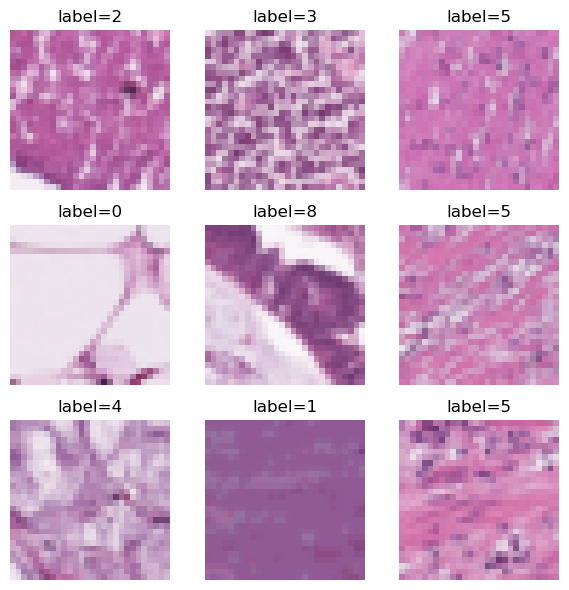

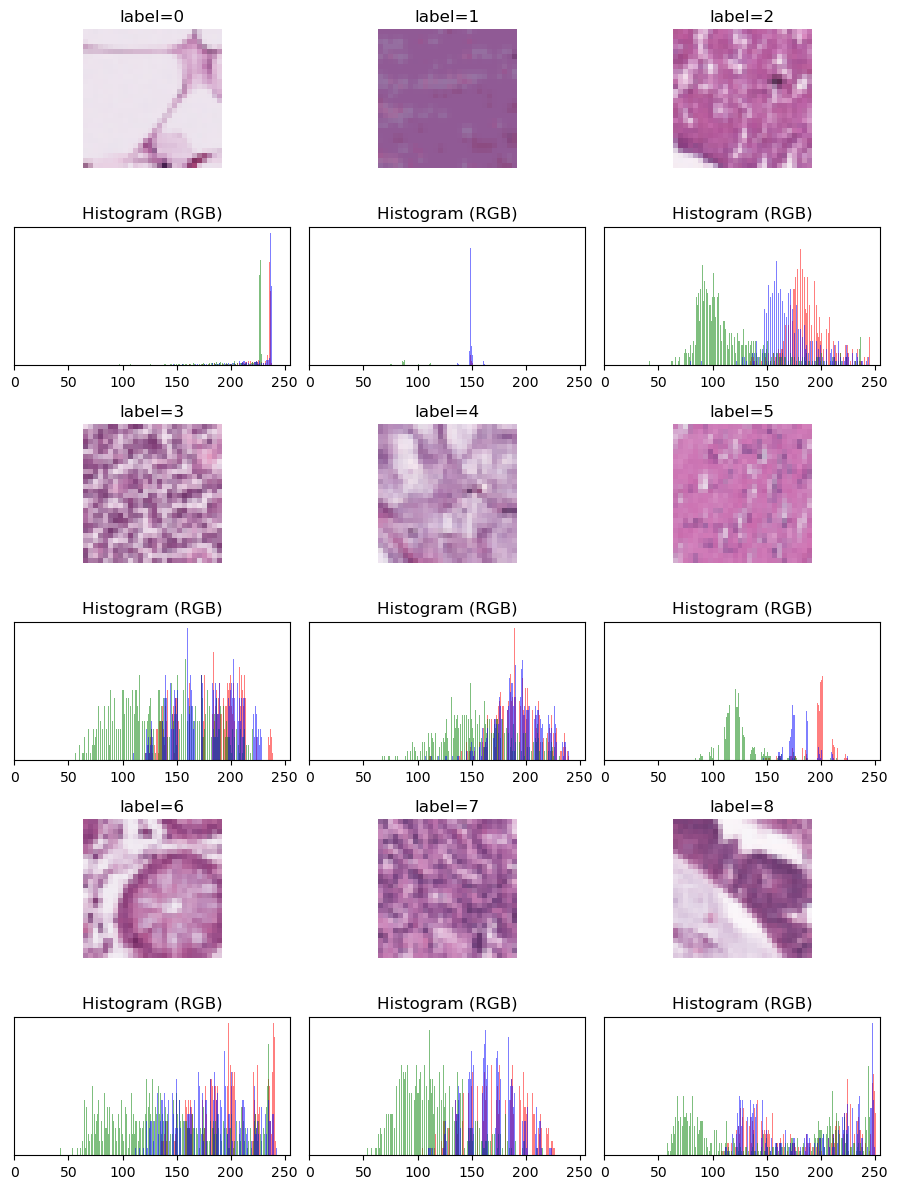

In [10]:
unique_labels = list(range(9))
selected_images = []
selected_labels = []

for label in unique_labels:
    idx = np.where(y_train == label)[0][0]  
    selected_images.append(X_train[idx])
    selected_labels.append(label)

fig, axes = plt.subplots(6, 3, figsize=(9, 12))  

for idx, (img, label) in enumerate(zip(selected_images, selected_labels)):
    row_img = (idx // 3) * 2    
    col = idx % 3               

    axes[row_img, col].imshow(img.astype('uint8'))
    axes[row_img, col].set_title(f'label={label}')
    axes[row_img, col].axis('off')

    if img.ndim == 3 and img.shape[-1] == 3:
        for c, color in enumerate(['r', 'g', 'b']):
            axes[row_img + 1, col].hist(img[:, :, c].ravel(), bins=256, color=color, alpha=0.5)
        axes[row_img + 1, col].set_title('Histogram (RGB)')
    else:
        axes[row_img + 1, col].hist(img.ravel(), bins=256, color='gray')
        axes[row_img + 1, col].set_title('Histogram (Gray)')

    axes[row_img + 1, col].set_xlim([0, 255])
    axes[row_img + 1, col].set_yticks([])

plt.tight_layout()
plt.show()

## 2. Algorithm design and setup

### Algorithm of choice from first six weeks of course

In [11]:
# 1. data flattening
X_train_flat_SVM = X_train.reshape(len(X_train), -1)
X_valid_flat_SVM = X_valid.reshape(X_valid.shape[0], -1)
X_test_flat_SVM = X_test.reshape(X_test.shape[0], -1)

print(f"Shape of X_test_flat: {X_train_flat_SVM.shape}")
print(f"Shape of X_val_flat: {X_valid_flat_SVM.shape}")
print(f"Shape of X_test_flat: {X_test_flat_SVM.shape}")


Shape of X_test_flat: (25600, 2352)
Shape of X_val_flat: (6400, 2352)
Shape of X_test_flat: (8000, 2352)


In [12]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('svc', SVC(kernel='rbf'))
])

In [13]:
# --- 1.3 Retrain on full train set & evaluate on test set ---
pipe.fit(X_train_flat_SVM, y_train)


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()), ('svc', SVC())])

In [14]:
valid_pred = pipe.predict(X_valid_flat_SVM)
print("Test accuracy (default params):",
      accuracy_score(y_valid, valid_pred))
print(classification_report(y_valid, valid_pred))

Test accuracy (default params): 0.64984375
              precision    recall  f1-score   support

           0       0.82      0.96      0.88       698
           1       0.96      0.86      0.91       686
           2       0.47      0.29      0.35       701
           3       0.93      0.82      0.87       731
           4       0.60      0.60      0.60       590
           5       0.61      0.66      0.64       858
           6       0.38      0.21      0.27       546
           7       0.48      0.51      0.49       651
           8       0.53      0.78      0.63       939

    accuracy                           0.65      6400
   macro avg       0.64      0.63      0.63      6400
weighted avg       0.65      0.65      0.64      6400



### Fully connected neural network

In [40]:
X_train_MLP = X_train.reshape(len(X_train), -1)
X_valid_MLP = X_valid.reshape(X_valid.shape[0], -1)
X_test_MLP = X_test.reshape(len(X_test), -1)
#Pixel processing
scaler = StandardScaler().fit(X_train_MLP)
X_train_MLP = scaler.transform(X_train_MLP)
X_test_MLP = scaler.transform(X_test_MLP)
X_valid_MLP = scaler.transform(X_valid_MLP)

In [41]:
# #One-hot
num_classes = len(np.unique(y_train))  
y_train_MLP = to_categorical(y_train, num_classes)
y_valid_MLP = to_categorical(y_valid, num_classes)
y_test_MLP = to_categorical(y_test, num_classes)

print(f"X_train shape: {X_train_MLP.shape}")
print(f"y_train shape: {y_train_MLP.shape}")

X_train shape: (25600, 2352)
y_train shape: (25600, 9)


In [44]:
mlp_model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_MLP.shape[1],)),  # 替代 Flatten
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])



C:\Users\yang\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [46]:
mlp_model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [48]:
history_mlp = mlp_model.fit(
    X_train_MLP, y_train_MLP,
    validation_data=(X_valid_MLP, y_valid_MLP),
    epochs=30,
    batch_size=128,
)

Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3063 - loss: 2.3228 - val_accuracy: 0.4583 - val_loss: 1.3103
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4583 - loss: 1.3933 - val_accuracy: 0.5269 - val_loss: 1.2060
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4976 - loss: 1.2868 - val_accuracy: 0.5486 - val_loss: 1.1596
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5184 - loss: 1.2401 - val_accuracy: 0.5689 - val_loss: 1.1232
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5434 - loss: 1.1883 - val_accuracy: 0.5773 - val_loss: 1.0911
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5490 - loss: 1.1487 - val_accuracy: 0.5969 - val_loss: 1.0692
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5639 - loss: 1.1247 - val_accuracy: 0.5769 - val_loss: 1.0747
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5628 - loss: 1.1075 - val_accuracy: 0

In [50]:
test_loss, test_accuracy = mlp_model.evaluate(X_valid_MLP, y_valid_MLP)
print(f"Test accuracy: {test_accuracy:.4f}")

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6424 - loss: 0.9723
Test accuracy: 0.6414


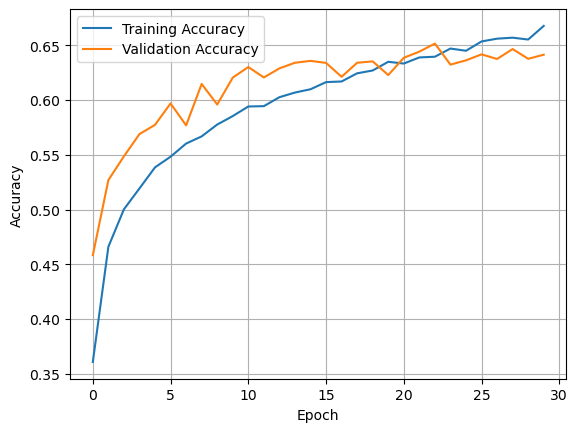

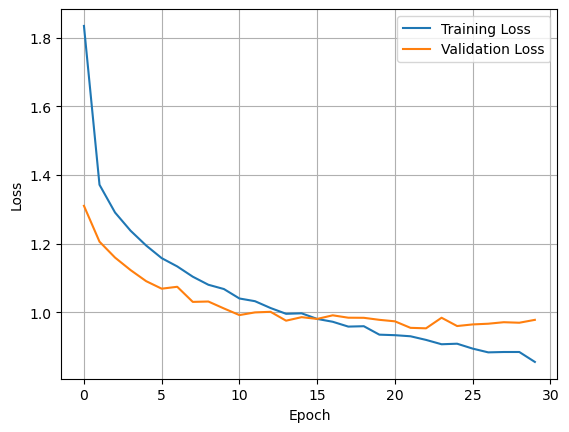

In [52]:
plt.figure()
plt.plot(history_mlp.history['accuracy'], label='Training Accuracy')
plt.plot(history_mlp.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(history_mlp.history['loss'], label='Training Loss')
plt.plot(history_mlp.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Convolutional neural network

In [127]:
X_train_CNN = X_train / 255.0
X_test_CNN = X_test / 255.0
X_valid_CNN = X_valid / 255.0

In [128]:
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def plot_image(image):
    # Remove redundant extra dimension
    if image.shape[-1] == 1:
        image = image.squeeze(axis=-1)
        
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    # Remove redundant extra dimension
    if image.shape[-1] == 1:
        image = image.squeeze(axis=-1)
        
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")
    
def plot_examples(data, n_rows=4, n_cols=10):
    """Plot a grid of images which are encoded as numpy arrays."""
    
    # Remove redundant extra dimension
    if data.shape[-1] == 1:
        data = data.squeeze(axis=-1)
        
    
    # Size figure depending on the size of the grid
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
    
    for row in range(n_rows):
        for col in range(n_cols):
            
            # Get next index of image
            index = n_cols * row + col
            
            # Plot the image at appropriate place in grid
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(data[index], cmap="binary")
            plt.axis('off')
            
    plt.show()

In [129]:
model_CNN_0 = keras.Sequential([
    keras.Input(shape=(28, 28, 3)),

    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(128, kernel_size=(3, 3), activation="sigmoid"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dropout(0.7),
    keras.layers.Dense(9, activation="softmax"),
])


In [130]:
model_CNN_0.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 26, 26, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,409 (368.79 KB)

 Trainable params: 94,409 (368.79 KB)

 Non-trainable params: 0 (0.00 B)

In [131]:
# Compile model with loss, optimiser, and metrics
model_CNN_0.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [132]:
# Train the model for 10 epochs with batch size 128
batch_size = 128
epochs = 15
history = model_CNN_0.fit(X_train_CNN, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_valid_CNN, y_valid))


Epoch 1/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.1417 - loss: 2.2604 - val_accuracy: 0.2839 - val_loss: 1.9513
Epoch 2/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.2828 - loss: 1.9325 - val_accuracy: 0.3328 - val_loss: 1.7916
Epoch 3/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.3367 - loss: 1.7962 - val_accuracy: 0.4206 - val_loss: 1.6351
Epoch 4/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.3973 - loss: 1.6526 - val_accuracy: 0.4580 - val_loss: 1.4688
Epoch 5/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4416 - loss: 1.5177 - val_accuracy: 0.5200 - val_loss: 1.3202
Epoch 6/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4869 - loss: 1.3897 - val_accuracy: 0.5506 - val_loss: 1.2574
Epoch 7/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5108 - loss: 1.3244 - val_accuracy: 0.5828 - val_loss: 1.1433
Epoch 8/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5364 - loss: 1.2624 - val_accu

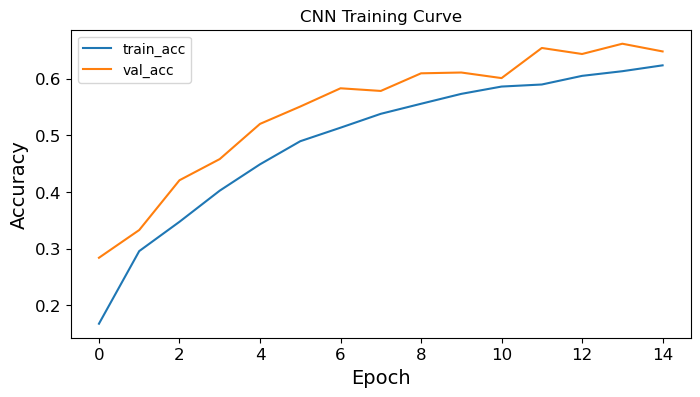

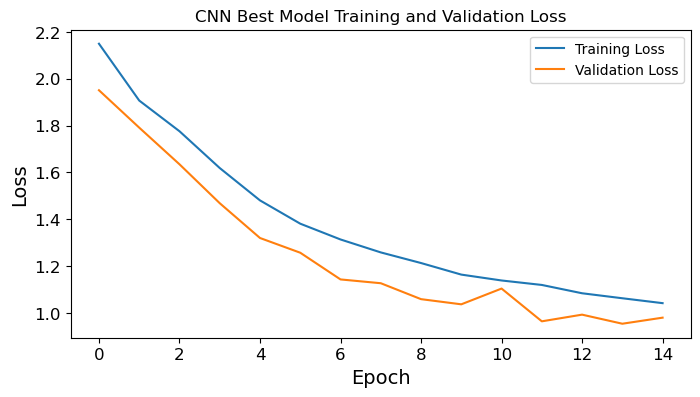

In [133]:
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.title('CNN Training Curve')
plt.show()
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Best Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 3. Hyperparameter tuning

### Algorithm of choice from first six weeks of course

In [15]:
# 4. Define the hyperparameter grid
param_grid= {
    'pca__n_components': [10, 15, 25, 50],
    'svc__C':            [0.1, 1, 10, 20],
    'svc__gamma':        ['scale', 1e-4, 1e-3, 1e-2, 1e-1]
}


In [16]:
param_combinations = [
    (n_comp, C, gamma)
    for n_comp in param_grid['pca__n_components']
    for C      in param_grid['svc__C']
    for gamma  in param_grid['svc__gamma']
]

def eval_params(n, c, g):
    pipe.set_params(pca__n_components=n, svc__C=c, svc__gamma=g)
    pipe.fit(X_train_flat_SVM, y_train)
    score = pipe.score(X_valid_flat_SVM, y_valid)
    return score, n, c, g

all_results = Parallel(n_jobs=-1, verbose=1)(
    delayed(eval_params)(n, c, g)
    for n, c, g in param_combinations
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  3.6min finished


Best validation score: 0.6900
Best hyperparameters: {'pca__n_components': 15, 'svc__C': 10, 'svc__gamma': 'scale'}

Final test set evaluation:
Accuracy: 0.6903
Training time: 8.57 seconds
Prediction time: 4.75 seconds

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.96      0.90       698
           1       0.94      0.87      0.90       686
           2       0.52      0.40      0.45       701
           3       0.91      0.91      0.91       731
           4       0.70      0.64      0.67       590
           5       0.66      0.69      0.68       858
           6       0.51      0.38      0.44       546
           7       0.52      0.56      0.54       651
           8       0.57      0.71      0.63       939

    accuracy                           0.69      6400
   macro avg       0.69      0.68      0.68      6400
weighted avg       0.69      0.69      0.69      6400



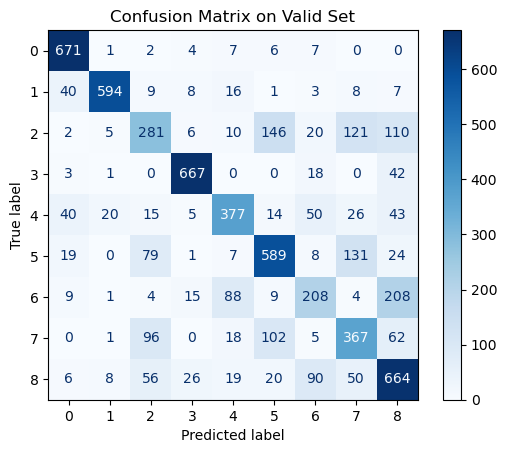

In [17]:
best_score, best_n_comp, best_C, best_gamma = max(all_results, key=lambda x: x[0])
best_params = {
    'pca__n_components': best_n_comp,
    'svc__C':            best_C,
    'svc__gamma':        best_gamma
}

print(f"Best validation score: {best_score:.4f}")
print("Best hyperparameters:", best_params)

# 5. Retrain on full training set
pipe.set_params(**best_params)
start_train = time.time()
pipe.fit(X_train_flat_SVM, y_train)
end_train = time.time()

# 7. Evaluate on the test set
start_pred = time.time()
y_pred = pipe.predict(X_valid_flat_SVM)
end_pred = time.time()

# 8. Metrics
accuracy = accuracy_score(y_valid, y_pred)
train_time = end_train - start_train
pred_time = end_pred - start_pred
cm = confusion_matrix(y_valid, y_pred)

print("\nFinal test set evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Training time: {train_time:.2f} seconds")
print(f"Prediction time: {pred_time:.2f} seconds")
print("\nClassification Report:\n", classification_report(y_valid, y_pred))

# 9. Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Valid Set")
plt.show()

### Fully connected neural network

In [54]:
X_train_MLP = X_train.reshape(len(X_train), -1)
X_valid_MLP = X_valid.reshape(X_valid.shape[0], -1)
X_test_MLP = X_test.reshape(len(X_test), -1)
#Pixel processing
scaler = StandardScaler().fit(X_train_MLP)
X_train_MLP = scaler.transform(X_train_MLP)
X_test_MLP = scaler.transform(X_test_MLP)
X_valid_MLP = scaler.transform(X_valid_MLP)

# #One-hot
num_classes = len(np.unique(y_train))  
y_train_MLP = to_categorical(y_train, num_classes)
y_valid_MLP = to_categorical(y_valid, num_classes)
y_test_MLP = to_categorical(y_test, num_classes)

print(f"X_train shape: {X_train_MLP.shape}")
print(f"y_train shape: {y_train_MLP.shape}")


X_train shape: (25600, 2352)
y_train shape: (25600, 9)


In [28]:
num_classes = y_train_MLP.shape[1]
# Define a function for KerasTuner to use for hyperparameter search
def build_mlp(hp):
    model = Sequential()
 # Add the input layer
    model.add(Dense(units=hp.Choice('input_units', values=[64, 128, 256]), 
                    activation='relu',
                    input_shape=(X_train_MLP.shape[1],)))  

    #  Dynamically add hidden layers (1-2), and search for the units and activation of each layer as hyperparameters
    for i in range(hp.Int('num_layers', 1, 3)): #Hyperparameter 1: Number of hidden Layers 
        model.add(Dense(
             units=hp.Choice(f'units_{i}', values=[128, 256, 512]),# Hyperparameter 2：Number of neurons per layer (units)
            activation=hp.Choice(f'activation_{i}', values=['relu', 'tanh']) #Hyperparameter 3 activation function at each level
        ))
        
    model.add(Dropout(rate=hp.Choice('dropout_rate', values=[0.3, 0.5, 0.6])))  
    
    model.add(Dense(num_classes, activation='softmax'))


    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', values=[0.001, 0.005, 0.0001]) #Hyperparameter4  Learning Rate
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model



In [56]:
# KerasTuner
tuner = RandomSearch(
    build_mlp,                         
    objective='val_accuracy',           #Maximize the accuracy of the verification set
    max_trials=20,                      # Try 20 different combinations of hyperparameters
    executions_per_trial=1,             
    overwrite=True,
    directory='mlp_tuner_dir',      
    project_name='mlp_tuning'            
)

C:\Users\yang\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [58]:
# EarlyStopping 
earlystop = EarlyStopping(
    monitor='val_accuracy',       
    patience=5,                   # It stopped after five consecutive rounds without improvement
    restore_best_weights=True     # Restore to the optimal model parameters
)

In [60]:

tuner.search(X_train_MLP, y_train_MLP,
             validation_data=(X_valid_MLP, y_valid_MLP),
             epochs=30,
             callbacks=[earlystop],
             batch_size=128)

Trial 20 Complete [00h 00m 21s]
val_accuracy: 0.6490625143051147

Best val_accuracy So Far: 0.6628124713897705
Total elapsed time: 00h 06m 39s


In [62]:
best_hp = tuner.get_best_hyperparameters(1)[0]

print("\nBest MLP Hyperparameters:")
print(f"input_units:   {best_hp.get('input_units')}")
print(f"num_layers:    {best_hp.get('num_layers')}")
for i in range(best_hp.get('num_layers')):
    print(f"units_{i}:     {best_hp.get(f'units_{i}')}")
    print(f"activation_{i}: {best_hp.get(f'activation_{i}')}")
print(f"dropout_rate:  {best_hp.get('dropout_rate')}")
print(f"learning_rate: {best_hp.get('learning_rate')}")


Best MLP Hyperparameters:
input_units:   128
num_layers:    3
units_0:     512
activation_0: tanh
units_1:     512
activation_1: relu
units_2:     512
activation_2: relu
dropout_rate:  0.5
learning_rate: 0.0001


In [86]:
tuner.results_summary()

Results summary
Results in mlp_tuner_dir\mlp_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 07 summary
Hyperparameters:
input_units: 128
num_layers: 3
units_0: 512
activation_0: tanh
dropout_rate: 0.5
learning_rate: 0.0001
units_1: 512
activation_1: relu
units_2: 512
activation_2: relu
Score: 0.6628124713897705

Trial 04 summary
Hyperparameters:
input_units: 128
num_layers: 3
units_0: 512
activation_0: relu
dropout_rate: 0.6
learning_rate: 0.0001
units_1: 128
activation_1: relu
units_2: 128
activation_2: relu
Score: 0.659375011920929

Trial 12 summary
Hyperparameters:
input_units: 128
num_layers: 1
units_0: 512
activation_0: relu
dropout_rate: 0.6
learning_rate: 0.001
units_1: 512
activation_1: relu
units_2: 256
activation_2: relu
Score: 0.6503124833106995

Trial 19 summary
Hyperparameters:
input_units: 64
num_layers: 3
units_0: 512
activation_0: relu
dropout_rate: 0.3
learning_rate: 0.0001
units_1: 256
activation_1: tanh
units_2: 128
activation_2:

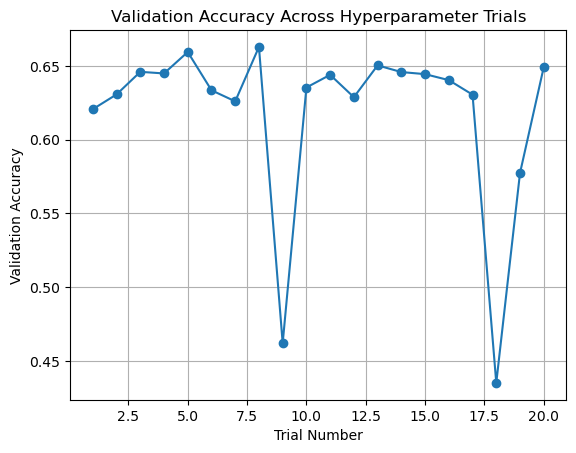

In [74]:
val_accuracies = []

for trial in tuner.oracle.trials.values():
    if 'val_accuracy' in trial.metrics.metrics:
        val_acc = trial.metrics.get_last_value('val_accuracy')
        if val_acc is not None:
            val_accuracies.append(val_acc)

plt.figure()
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o')
plt.title('Validation Accuracy Across Hyperparameter Trials')
plt.xlabel('Trial Number')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

In [76]:
# Obtain the best model with the highest accuracy of the validation set in the hyperparameter function
best_model = tuner.get_best_models(num_models=1)[0]

C:\Users\yang\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\yang\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [78]:
#Evaluate the best model in the test set
test_loss, test_accuracy = best_model.evaluate(X_test_MLP, y_test_MLP)
print(f"Best MLP Test Accuracy: {test_accuracy:.4f}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6666 - loss: 0.9094
Best MLP Test Accuracy: 0.6628


In [80]:
# Obtain the training history of the model
history = best_model.fit(
    X_train_MLP, y_train_MLP,
    validation_data=(X_valid_MLP, y_valid_MLP),  
    epochs=30,
    batch_size=128,
)

Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7684 - loss: 0.6343 - val_accuracy: 0.6603 - val_loss: 0.9376
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7868 - loss: 0.5862 - val_accuracy: 0.6591 - val_loss: 0.9608
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8029 - loss: 0.5540 - val_accuracy: 0.6567 - val_loss: 0.9898
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8135 - loss: 0.5216 - val_accuracy: 0.6558 - val_loss: 1.0131
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8274 - loss: 0.4886 - val_accuracy: 0.6509 - val_loss: 1.0667
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8379 - loss: 0.4608 - val_accuracy: 0.6480 - val_loss: 1.1010
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8526 - loss: 0.4296 - val_accuracy: 0.6483 - val_loss: 1.1565
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8635 - loss: 0.3987 - val_accur

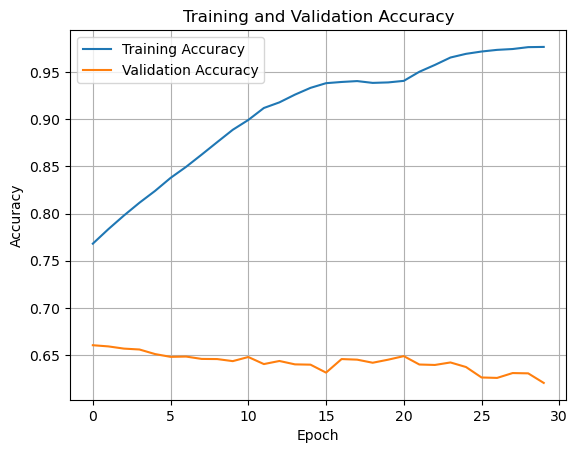

In [82]:
# Draw the accuracy curve of the training and validation sets
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

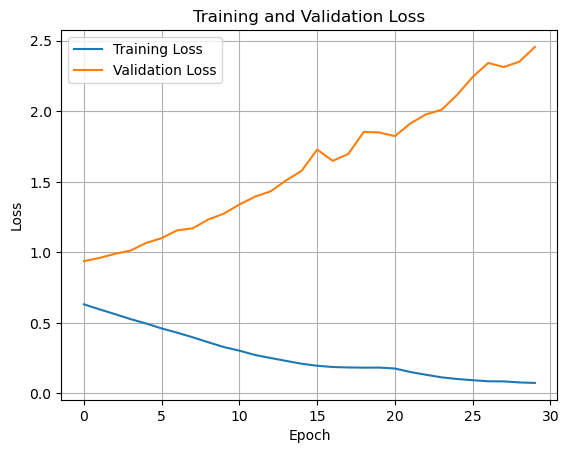

In [84]:
# Draw the loss curves of the training and validation sets
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Convolutional neural network

In [126]:
def build_model(hp):
    model = keras.models.Sequential()
    
    model.add(keras.layers.Input(shape=(28, 28, 3)))
    
    model.add(layers.Conv2D(filters=32, kernel_size=3, padding='same'))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    
    model.add(layers.Conv2D(filters=64, kernel_size=3, padding='same'))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=2))

    model.add(layers.Conv2D(filters=128, kernel_size=3, padding='same'))
    model.add(layers.Activation(hp.Choice("activate_function", values=["sigmoid","relu"])))
    model.add(layers.MaxPooling2D(pool_size=2))

    model.add(layers.Flatten())

    dropout_rate = hp.Choice("dropout_rate", values=[0.3, 0.5, 0.7])
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(9, activation="softmax"))

    optimizer_choice = "adam"
    learning_rate = hp.Choice("learning_rate", values=[0.01, 0.001])

    if optimizer_choice == "adam":
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [107]:

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=12,
    executions_per_trial=1,
    overwrite=True,
    directory="keras_tuning_results_CNN",
    project_name="CNN_Assignment2"
)

In [108]:
tuner.search(X_train_CNN, y_train, epochs=15, batch_size = 128, validation_data=(X_valid_CNN, y_valid))

Trial 12 Complete [00h 01m 26s]
val_accuracy: 0.14671875536441803

Best val_accuracy So Far: 0.8342187404632568
Total elapsed time: 00h 19m 13s


In [119]:
tuner.results_summary()

Results summary
Results in keras_tuning_results_CNN\CNN_Assignment2
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 04 summary
Hyperparameters:
activate_function: relu
dropout_rate: 0.3
learning_rate: 0.001
Score: 0.8342187404632568

Trial 09 summary
Hyperparameters:
activate_function: relu
dropout_rate: 0.7
learning_rate: 0.001
Score: 0.8140624761581421

Trial 02 summary
Hyperparameters:
activate_function: relu
dropout_rate: 0.5
learning_rate: 0.001
Score: 0.8139062523841858

Trial 05 summary
Hyperparameters:
activate_function: sigmoid
dropout_rate: 0.5
learning_rate: 0.001
Score: 0.7867187261581421

Trial 07 summary
Hyperparameters:
activate_function: sigmoid
dropout_rate: 0.7
learning_rate: 0.001
Score: 0.7867187261581421

Trial 03 summary
Hyperparameters:
activate_function: sigmoid
dropout_rate: 0.3
learning_rate: 0.001
Score: 0.7778124809265137

Trial 06 summary
Hyperparameters:
activate_function: relu
dropout_rate: 0.3
learning_rate: 0.01
Score: 0.70

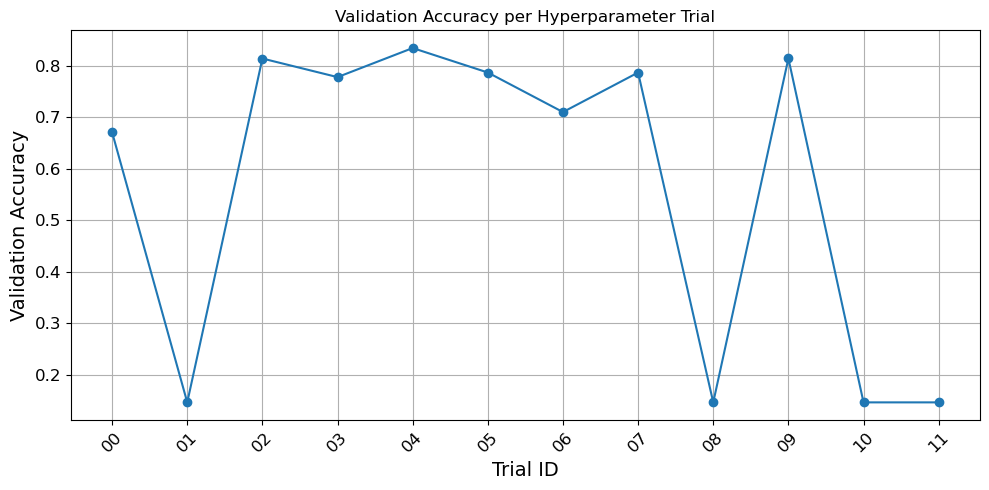

In [109]:
# Retrieve every model's accuracy
val_accuracies = []
trial_ids = []

for trial_id, trial in tuner.oracle.trials.items():
    score = trial.score  # val_accuracy
    val_accuracies.append(score)
    trial_ids.append(trial_id)

plt.figure(figsize=(10, 5))
plt.plot(trial_ids, val_accuracies, marker='o')
plt.xticks(rotation=45)
plt.xlabel("Trial ID")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy per Hyperparameter Trial")
plt.grid(True)
plt.tight_layout()
plt.show()

In [136]:
best_hps = tuner.get_best_hyperparameters()[0]
model_CNN_1 = build_model(best_hps)
model_CNN_1.summary()
best_hps = tuner.get_best_hyperparameters()[0]
print("Best hyperparameters:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 28, 28, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 9)              │        10,377 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,625 (404.79 KB)

 Trainable params: 103,625 (404.79 KB)

 Non-trainable params: 0 (0.00 B)

Best hyperparameters:
activate_function: relu
dropout_rate: 0.3
learning_rate: 0.001


## 4. Final models
In this section, please ensure to include cells to train each model with its best hyperparmater combination independently of the hyperparameter tuning cells, i.e. don't rely on the hyperparameter tuning cells having been run.

### Algorithm of choice from first six weeks of course

SVM training time: 8.35s
SVM prediction time: 5.80s

SVM test accuracy: 0.6867

SVM classification report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       873
           1       0.93      0.89      0.91       858
           2       0.48      0.38      0.42       877
           3       0.91      0.91      0.91       914
           4       0.67      0.62      0.64       737
           5       0.66      0.66      0.66      1072
           6       0.52      0.40      0.46       682
           7       0.50      0.55      0.53       813
           8       0.58      0.71      0.64      1174

    accuracy                           0.69      8000
   macro avg       0.68      0.68      0.68      8000
weighted avg       0.68      0.69      0.68      8000



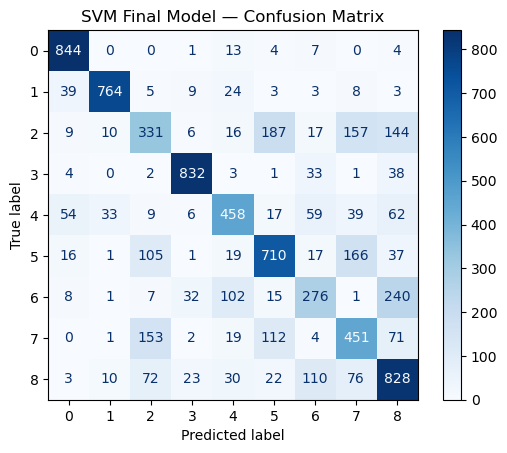

In [19]:
# --- SVM Final Model ---
# 1. Define best hyperparameters explicitly
best_svm_params = {
    'pca__n_components': 15,
    'svc__C':             10,
    'svc__gamma':        'scale'
}

# 2. Rebuild pipeline with best params
svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca',     PCA(n_components=best_svm_params['pca__n_components'])),
    ('svc',     SVC(kernel='rbf',
                    C=best_svm_params['svc__C'],
                    gamma=best_svm_params['svc__gamma']))
])

# 3. Train on full training set
start_train = time.time()
svm_pipe.fit(X_train_flat_SVM, y_train)
print(f"SVM training time: {time.time() - start_train:.2f}s")

# 4. Predict on test set
start_pred = time.time()
y_pred_svm = svm_pipe.predict(X_test_flat_SVM)
print(f"SVM prediction time: {time.time() - start_pred:.2f}s\n")

# 5. Report metrics
acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM test accuracy: {acc_svm:.4f}\n")
print("SVM classification report:")
print(classification_report(y_test, y_pred_svm))

# 6. Confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("SVM Final Model — Confusion Matrix")
plt.show()

### Fully connected neural network

C:\Users\yang\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.4174 - loss: 1.5598 - val_accuracy: 0.5873 - val_loss: 1.0820
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5936 - loss: 1.0681 - val_accuracy: 0.6225 - val_loss: 0.9868
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6453 - loss: 0.9438 - val_accuracy: 0.6322 - val_loss: 0.9480
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6823 - loss: 0.8472 - val_accuracy: 0.6372 - val_loss: 0.9308
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7114 - loss: 0.7745 - val_accuracy: 0.6417 - val_loss: 0.9258
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7385 - loss: 0.7147 - val_accuracy: 0.6438 - val_loss: 0.9324
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7647 - loss: 0.6452 - val_accuracy: 0.6361 - val_loss: 0.9727
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7906 - loss: 0.5837 - val_accu

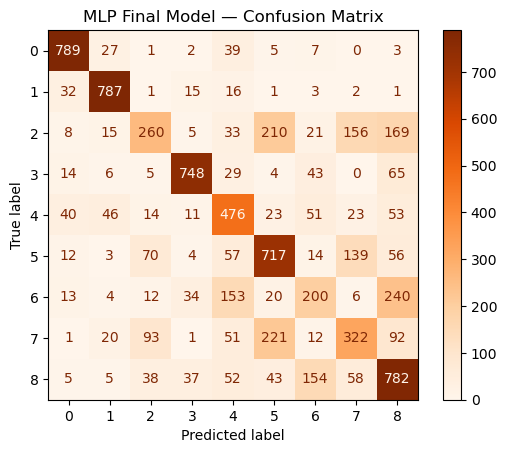

In [90]:
# --- MLP Final Model ---
# 1. Define best hyperparameters explicitly
best_mlp_params = {
    'input_units':   128,
    'num_layers':    3,
    'units_0':       512,
    'activation_0': 'tanh',
    'units_1':       512,
    'activation_1': 'relu',
    'units_2':       512,
    'activation_2': 'relu',
    'dropout_rate':  0.5,
    'learning_rate': 0.0001
}

# 2. Rebuild model with best params
def build_final_mlp(params):
    model = Sequential()
    
    # Input layer
    model.add(Dense(params['units_0'], activation=params['activation_0'], input_shape=(X_train_MLP.shape[1],)))
    
    # Hidden layers
    for i in range(params['num_layers']):
        model.add(Dense(units=params[f'units_{i}'],
                        activation=params[f'activation_{i}']))
    model.add(Dropout(rate=params['dropout_rate']))
    
    # Output layer
    model.add(Dense(y_train_MLP.shape[1], activation='softmax'))
    
    # Compile
    model.compile(
        optimizer=Adam(learning_rate=params['learning_rate']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

mlp_model = build_final_mlp(best_mlp_params)

# 3. Train on full training set
start_train = time.time()
mlp_model.fit(X_train_MLP, y_train_MLP,
              validation_data=(X_valid_MLP, y_valid_MLP),
              epochs=30,
              batch_size=128)
print(f"MLP training time: {time.time() - start_train:.2f}s")

# 4. Predict on test set
start_pred = time.time()
y_pred_prob = mlp_model.predict(X_test_MLP)
y_pred_mlp = np.argmax(y_pred_prob, axis=1)
y_true_mlp = np.argmax(y_test_MLP, axis=1)
print(f"MLP prediction time: {time.time() - start_pred:.2f}s\n")

# 5. Report metrics
acc_mlp = accuracy_score(y_true_mlp, y_pred_mlp)
print(f"MLP test accuracy: {acc_mlp:.4f}\n")
print("MLP classification report:")
print(classification_report(y_true_mlp, y_pred_mlp))

# 6. Confusion matrix
cm = confusion_matrix(y_true_mlp, y_pred_mlp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Oranges)
plt.title("MLP Final Model — Confusion Matrix")
plt.show()



### Convolutional neural network

Epoch 1/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.2615 - loss: 1.9404 - val_accuracy: 0.4772 - val_loss: 1.3736
Epoch 2/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4942 - loss: 1.3695 - val_accuracy: 0.5811 - val_loss: 1.1381
Epoch 3/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5705 - loss: 1.1663 - val_accuracy: 0.6570 - val_loss: 0.9893
Epoch 4/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6186 - loss: 1.0445 - val_accuracy: 0.6778 - val_loss: 0.9192
Epoch 5/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6427 - loss: 0.9814 - val_accuracy: 0.6670 - val_loss: 0.9273
Epoch 6/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6659 - loss: 0.9260 - val_accuracy: 0.7066 - val_loss: 0.8366
Epoch 7/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6793 - loss: 0.8925 - val_accuracy: 0.6847 - val_loss: 0.8585
Epoch 8/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6855 - loss: 0.8714 - val_accu

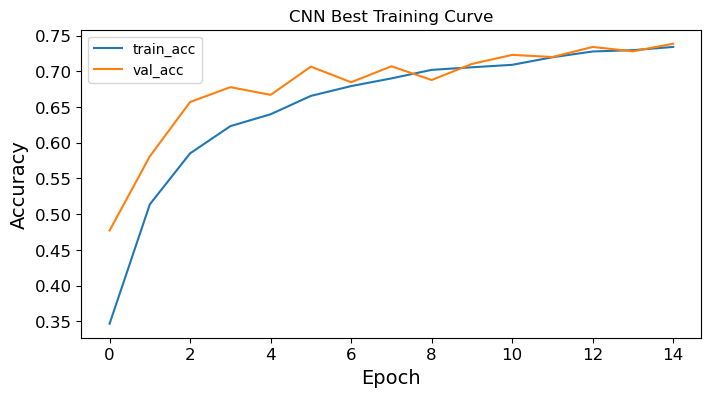

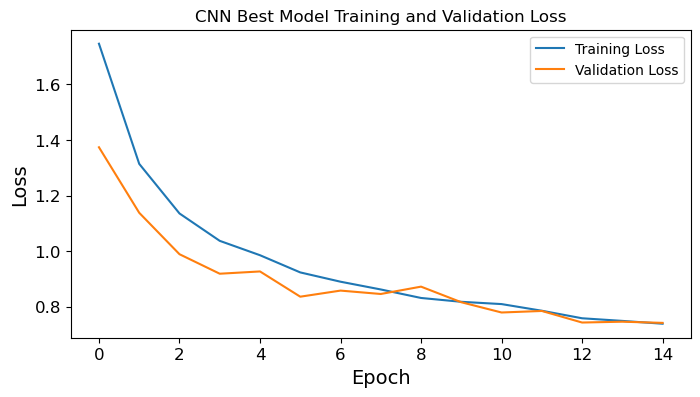

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7421 - loss: 0.7289
CNN's Best Test Accuracy: 0.7358
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91       873
           1       0.96      0.93      0.94       858
           2       0.59      0.55      0.57       877
           3       0.95      0.89      0.92       914
           4       0.72      0.74      0.73       737
           5       0.66      0.74      0.70      1072
           6       0.64      0.46      0.54       682
           7       0.45      0.62      0.52       813
           8       0.80      0.71      0.75      1174

    accuracy                           0.74      8000
   macro avg       0.74      0.73      0.73      8000
weighted avg       0.75      0.74      0.74      8000



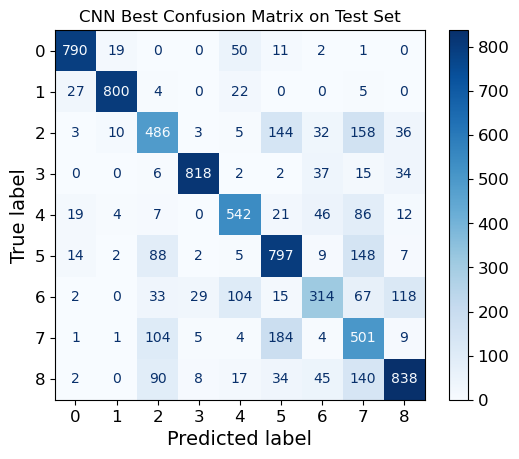

In [135]:
model_CNN_1 = keras.Sequential([
    keras.Input(shape=(28, 28, 3)),

    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(9, activation="softmax"),
])


model_CNN_1.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

batch_size = 128
epochs = 15
best_output = model_CNN_1.fit(X_train_CNN, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_valid_CNN, y_valid))
plt.figure(figsize=(8,4))
plt.plot(best_output.history['accuracy'], label='train_acc')
plt.plot(best_output.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.title('CNN Best Training Curve')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(best_output.history['loss'], label='Training Loss')
plt.plot(best_output.history['val_loss'], label='Validation Loss')
plt.title('CNN Best Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
test_loss, test_acc = model_CNN_1.evaluate(X_test_CNN, y_test)
print(f"CNN's Best Test Accuracy: {test_acc:.4f}")

y_pred = model_CNN_1.predict(X_test_CNN)
y_pred = np.argmax(y_pred, axis=1)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("CNN Best Confusion Matrix on Test Set")
plt.show()